<a href="https://colab.research.google.com/github/Abhishek500/ERA/blob/main/S8/ERA_S8_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/ERA V1')
from model import *

Mounted at /content/drive


In [2]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822 ,0.4465), (0.2470, 0.2435, 0.2616))])
test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822 ,0.4465), (0.2470, 0.2435, 0.2616))])



In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:

train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

# Load the CIFAR-10 test dataset
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)


100%|██████████| 170498071/170498071 [00:05<00:00, 29161386.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=32, num_workers=3, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = S8_Model_BN().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         Dropout2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         Dropout2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 10, 32, 32]             640
       BatchNorm2d-8           [-1, 10, 32, 32]              20
         Dropout2d-9           [-1, 10, 32, 32]               0
        MaxPool2d-10           [-1, 10, 16, 16]               0
           Conv2d-11           [-1, 16, 14, 14]           1,440
      BatchNorm2d-12           [-1, 16, 14, 14]              32

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    #return test_loss

In [9]:
model =  S8_Model_BN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.6531022787094116 Batch_id=1562 Accuracy=42.71: 100%|██████████| 1563/1563 [00:41<00:00, 37.38it/s]



Test set: Average loss: 1.2876, Accuracy: 5332/10000 (53.32%)

EPOCH: 1


Loss=1.253830909729004 Batch_id=1562 Accuracy=55.77: 100%|██████████| 1563/1563 [00:29<00:00, 52.75it/s]



Test set: Average loss: 1.0868, Accuracy: 6092/10000 (60.92%)

EPOCH: 2


Loss=1.0002756118774414 Batch_id=1562 Accuracy=61.45: 100%|██████████| 1563/1563 [00:29<00:00, 52.82it/s]



Test set: Average loss: 0.9525, Accuracy: 6604/10000 (66.04%)

EPOCH: 3


Loss=0.9470342397689819 Batch_id=1562 Accuracy=64.83: 100%|██████████| 1563/1563 [00:30<00:00, 51.60it/s]



Test set: Average loss: 0.8990, Accuracy: 6867/10000 (68.67%)

EPOCH: 4


Loss=0.7935793399810791 Batch_id=1562 Accuracy=67.14: 100%|██████████| 1563/1563 [00:29<00:00, 52.60it/s]



Test set: Average loss: 0.8365, Accuracy: 7044/10000 (70.44%)

EPOCH: 5


Loss=0.8453867435455322 Batch_id=1562 Accuracy=68.85: 100%|██████████| 1563/1563 [00:29<00:00, 52.62it/s]



Test set: Average loss: 0.8113, Accuracy: 7166/10000 (71.66%)

EPOCH: 6


Loss=0.7381391525268555 Batch_id=1562 Accuracy=69.99: 100%|██████████| 1563/1563 [00:29<00:00, 53.15it/s]



Test set: Average loss: 0.7883, Accuracy: 7248/10000 (72.48%)

EPOCH: 7


Loss=0.6851305365562439 Batch_id=1562 Accuracy=71.34: 100%|██████████| 1563/1563 [00:29<00:00, 52.48it/s]



Test set: Average loss: 0.7706, Accuracy: 7265/10000 (72.65%)

EPOCH: 8


Loss=0.8259275555610657 Batch_id=1562 Accuracy=71.73: 100%|██████████| 1563/1563 [00:29<00:00, 53.07it/s]



Test set: Average loss: 0.7832, Accuracy: 7234/10000 (72.34%)

EPOCH: 9


Loss=1.027341604232788 Batch_id=1562 Accuracy=72.39: 100%|██████████| 1563/1563 [00:29<00:00, 53.11it/s]



Test set: Average loss: 0.7497, Accuracy: 7434/10000 (74.34%)

EPOCH: 10


Loss=1.336658000946045 Batch_id=1562 Accuracy=73.21: 100%|██████████| 1563/1563 [00:29<00:00, 52.75it/s]



Test set: Average loss: 0.7494, Accuracy: 7393/10000 (73.93%)

EPOCH: 11


Loss=1.180537462234497 Batch_id=1562 Accuracy=73.60: 100%|██████████| 1563/1563 [00:31<00:00, 49.75it/s]



Test set: Average loss: 0.7350, Accuracy: 7460/10000 (74.60%)

EPOCH: 12


Loss=0.7463297843933105 Batch_id=1562 Accuracy=74.25: 100%|██████████| 1563/1563 [00:29<00:00, 52.29it/s]



Test set: Average loss: 0.7352, Accuracy: 7456/10000 (74.56%)

EPOCH: 13


Loss=0.7709333300590515 Batch_id=1562 Accuracy=74.63: 100%|██████████| 1563/1563 [00:30<00:00, 51.99it/s]



Test set: Average loss: 0.7165, Accuracy: 7578/10000 (75.78%)

EPOCH: 14


Loss=0.6857412457466125 Batch_id=1562 Accuracy=74.91: 100%|██████████| 1563/1563 [00:29<00:00, 52.68it/s]



Test set: Average loss: 0.7151, Accuracy: 7504/10000 (75.04%)

EPOCH: 15


Loss=0.7413074374198914 Batch_id=1562 Accuracy=75.33: 100%|██████████| 1563/1563 [00:30<00:00, 51.92it/s]



Test set: Average loss: 0.7018, Accuracy: 7589/10000 (75.89%)

EPOCH: 16


Loss=0.9495627880096436 Batch_id=1562 Accuracy=75.60: 100%|██████████| 1563/1563 [00:30<00:00, 51.07it/s]



Test set: Average loss: 0.7056, Accuracy: 7530/10000 (75.30%)

EPOCH: 17


Loss=0.653322696685791 Batch_id=1562 Accuracy=76.16: 100%|██████████| 1563/1563 [00:31<00:00, 49.11it/s]



Test set: Average loss: 0.7124, Accuracy: 7512/10000 (75.12%)

EPOCH: 18


Loss=0.5468999743461609 Batch_id=1562 Accuracy=76.31: 100%|██████████| 1563/1563 [00:30<00:00, 51.71it/s]



Test set: Average loss: 0.7198, Accuracy: 7536/10000 (75.36%)

EPOCH: 19


Loss=0.36792847514152527 Batch_id=1562 Accuracy=76.72: 100%|██████████| 1563/1563 [00:30<00:00, 51.49it/s]



Test set: Average loss: 0.6936, Accuracy: 7568/10000 (75.68%)



Text(0.5, 1.0, 'Test Accuracy')

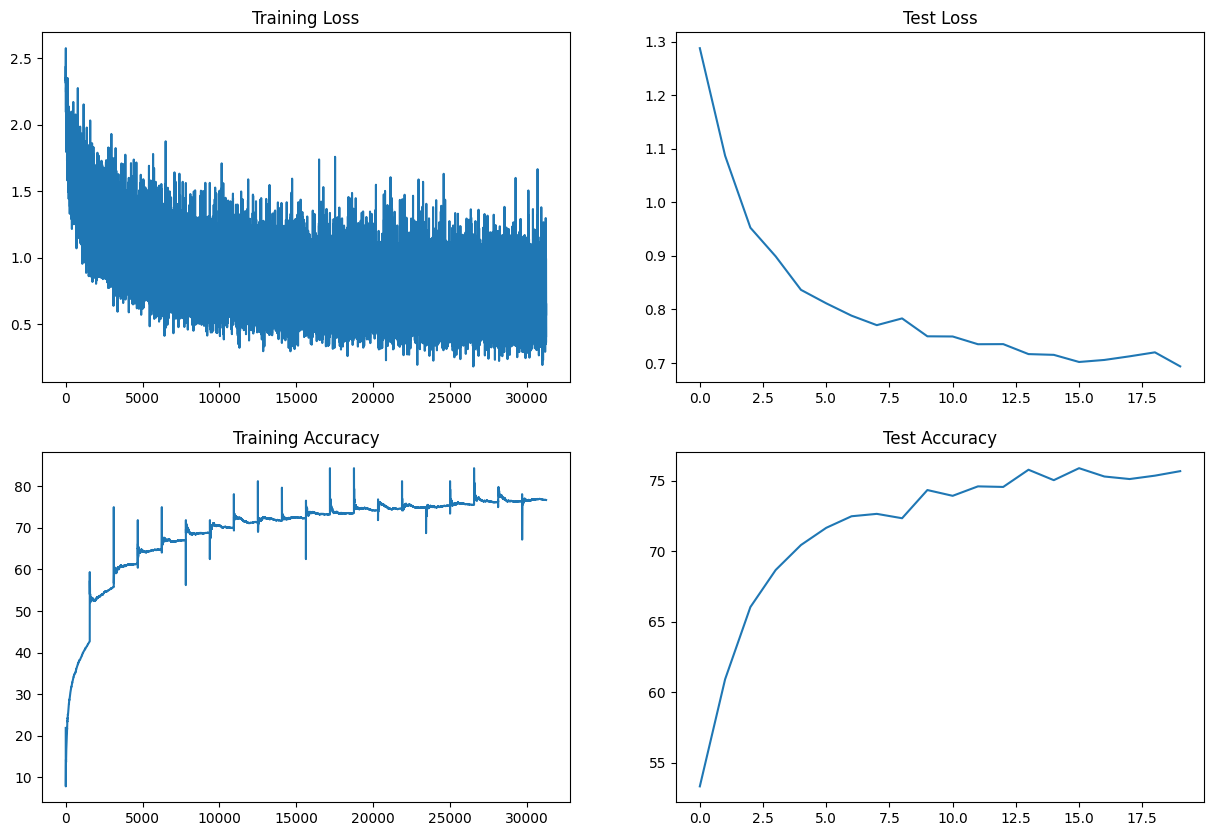

In [10]:
import matplotlib.pyplot as plt

t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

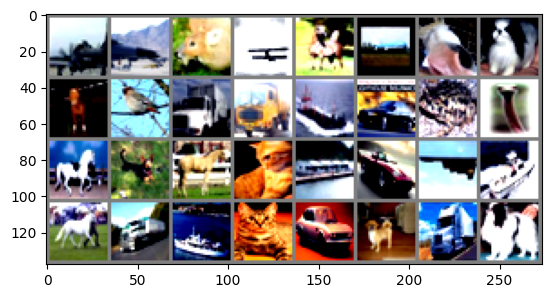

plane plane deer  plane horse plane horse dog   horse bird  truck truck ship  car   frog  bird  horse dog   horse cat   ship  car   plane ship  horse truck ship  cat   car   dog   truck dog  


In [ ]:
from torchvision.utils import make_grid
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)


imshow(make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))
